# Project 3 - Behavioral Cloning

In [98]:
# imports
import os
import pickle
import json
import random
import csv


import cv2
import numpy as np
import os
import csv
import glob

import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.model_selection import train_test_split

## Data Discovery and Analysis

### Data Discovery

In [119]:
data_dir = 'data2/'
logs = glob.glob(data_dir+'*.csv')

# logs = [ 'data2/driving_log_udacity.csv', 'data2/driving_log_recovery_march112017.csv']
# logs = [ 'data2/driving_log_udacity.csv']

print(logs)


['data2/driving_log_org_march112017.csv', 'data2/driving_log_normal_062017.csv', 'data2/driving_log_udacity.csv', 'data2/driving_log_recovery_march112017.csv']


In [120]:
# load training data
frames = []
for f in logs:
    df_tmp = pd.read_csv(f, header=0)
    df_tmp.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]
    print('log: ', f)
    print('len: ', len(df_tmp))
    frames.append(df_tmp)

# print(frames[3].tail())
df = pd.concat(frames,ignore_index=True)
print('total len: ', len(df))
# df
# # df.head()
# df.index
# df.columns
# df.values
# df.describe()
# df.dtypes
df.tail(3)

log:  data2/driving_log_org_march112017.csv
len:  5924
log:  data2/driving_log_normal_062017.csv
len:  596
log:  data2/driving_log_udacity.csv
len:  8035
log:  data2/driving_log_recovery_march112017.csv
len:  2190
total len:  16745


,center_image,left_image,right_image,steering_angle,throttle,break,speed
16742,IMG/center_2017_03_11_18_28_07_694.jpg,IMG/left_2017_03_11_18_28_07_694.jpg,IMG/right_2017_03_11_18_28_07_694.jpg,0.065448,0.0,0.0,26.99863
16743,IMG/center_2017_03_11_18_28_07_767.jpg,IMG/left_2017_03_11_18_28_07_767.jpg,IMG/right_2017_03_11_18_28_07_767.jpg,0.065448,0.0,0.0,26.78114
16744,IMG/center_2017_03_11_18_28_07_879.jpg,IMG/left_2017_03_11_18_28_07_879.jpg,IMG/right_2017_03_11_18_28_07_879.jpg,0.065448,0.0,0.0,26.42931


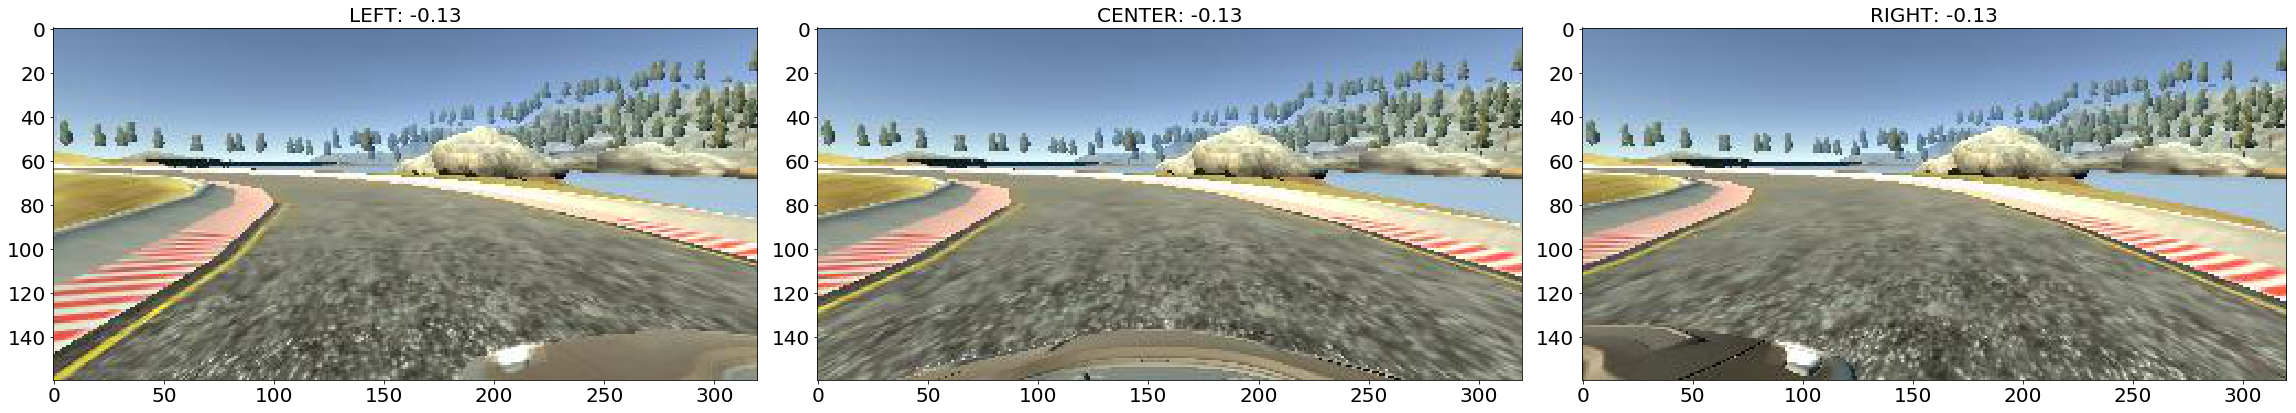

In [122]:
####################################################################
## Visualize left, center and right angle camera at the same moment
####################################################################
chk_idx =int(np.random.uniform(1, len(df)))
# print(chk_idx)
img_left = cv2.imread(data_dir+df["left_image"][chk_idx].strip())
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_center = cv2.imread(data_dir+df["center_image"][chk_idx].strip())
img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
img_right = cv2.imread(data_dir+df["right_image"][chk_idx].strip())
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
angle = df["steering_angle"][chk_idx]
plt.rcParams["figure.figsize"] = [32, 24]
plt.tick_params(axis='x', labelsize=25)

plt.subplot(1, 3, 1)
plt.imshow(img_left)
plt.title("LEFT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center)
plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_right)
plt.title("RIGHT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()

### Data Analysis

0 IMG/center_2017_03_11_18_04_19_364.jpg
1 IMG/center_2017_03_11_18_04_19_431.jpg
2 IMG/center_2017_03_11_18_04_19_500.jpg
img_height: 160
img_width: 320
img_channel: 3
min angle:  -0.9426954
max angle:  1.0
avg_samples_per_bin:  1000


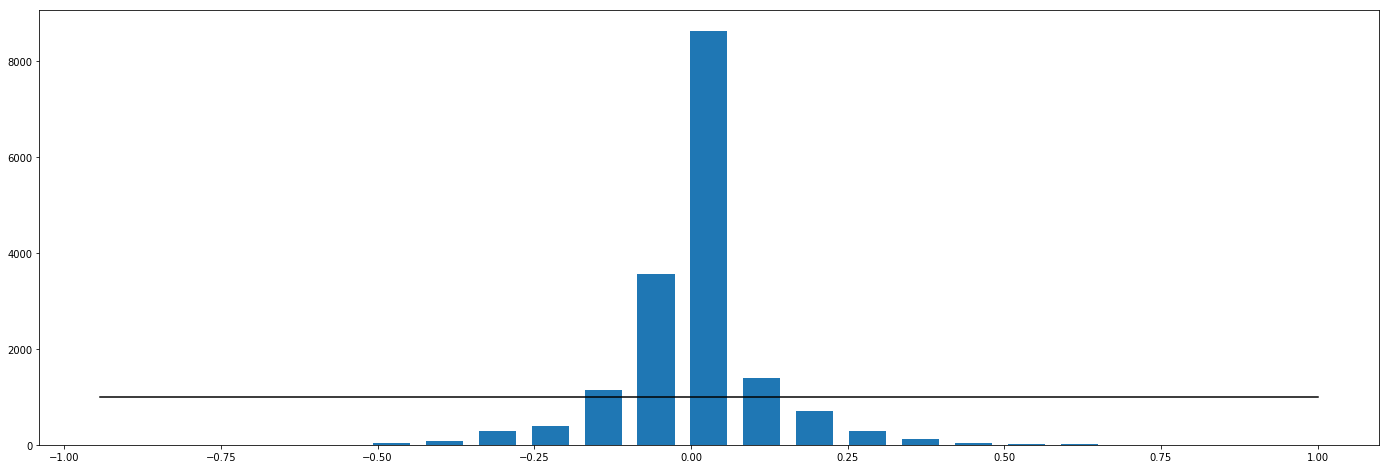

In [125]:
## data discovery
for i in range(3):
    print (i, '{:}'.format(df["center_image"][i]))

# This is a 160 pixel x 320 pixel x 3 channels
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL = img_center.shape
print("img_height:", IMG_HEIGHT)
print("img_width:", IMG_WIDTH)
print("img_channel:", IMG_CHANNEL)

min_angle = np.min(df["steering_angle"])
max_angle = np.max(df["steering_angle"])
print('min angle: ', min_angle)
print('max angle: ', max_angle)

# Time Series plot of steering angles
# plt.rcParams["figure.figsize"] = [24, 12]
# plt.figure(figsize=(6, 4))
# plt.title("Steering Angle Distribution")
# ts = df["steering_angle"]
# plt.plot(ts)

# plt.figure(figsize=(32,12))
# plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.075))
# plt.title("Steering Angle Histogram")
# plt.show()

# bins = np.arange(-1.0, 1.0, 0.05)
# hist, bin_edges = np.histogram(df["steering_angle"], bins=bins)
# # Create Steering Angle Bin Counts  
# steer_bin = []
# for i in range(len(hist)):
#     steer_bin.append([bins[i], bins[i+1], hist[i]])
    
# # Examine Steering Angle Bin Counts
# # steer_bin


# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 23
avg_samples_per_bin = 1000 #len(df["steering_angle"])/num_bins
print('avg_samples_per_bin: ', avg_samples_per_bin)
hist, bins = np.histogram(df["steering_angle"], num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(24,8))
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(df["steering_angle"]), np.max(df["steering_angle"])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

### Data Augmentation and Balancing

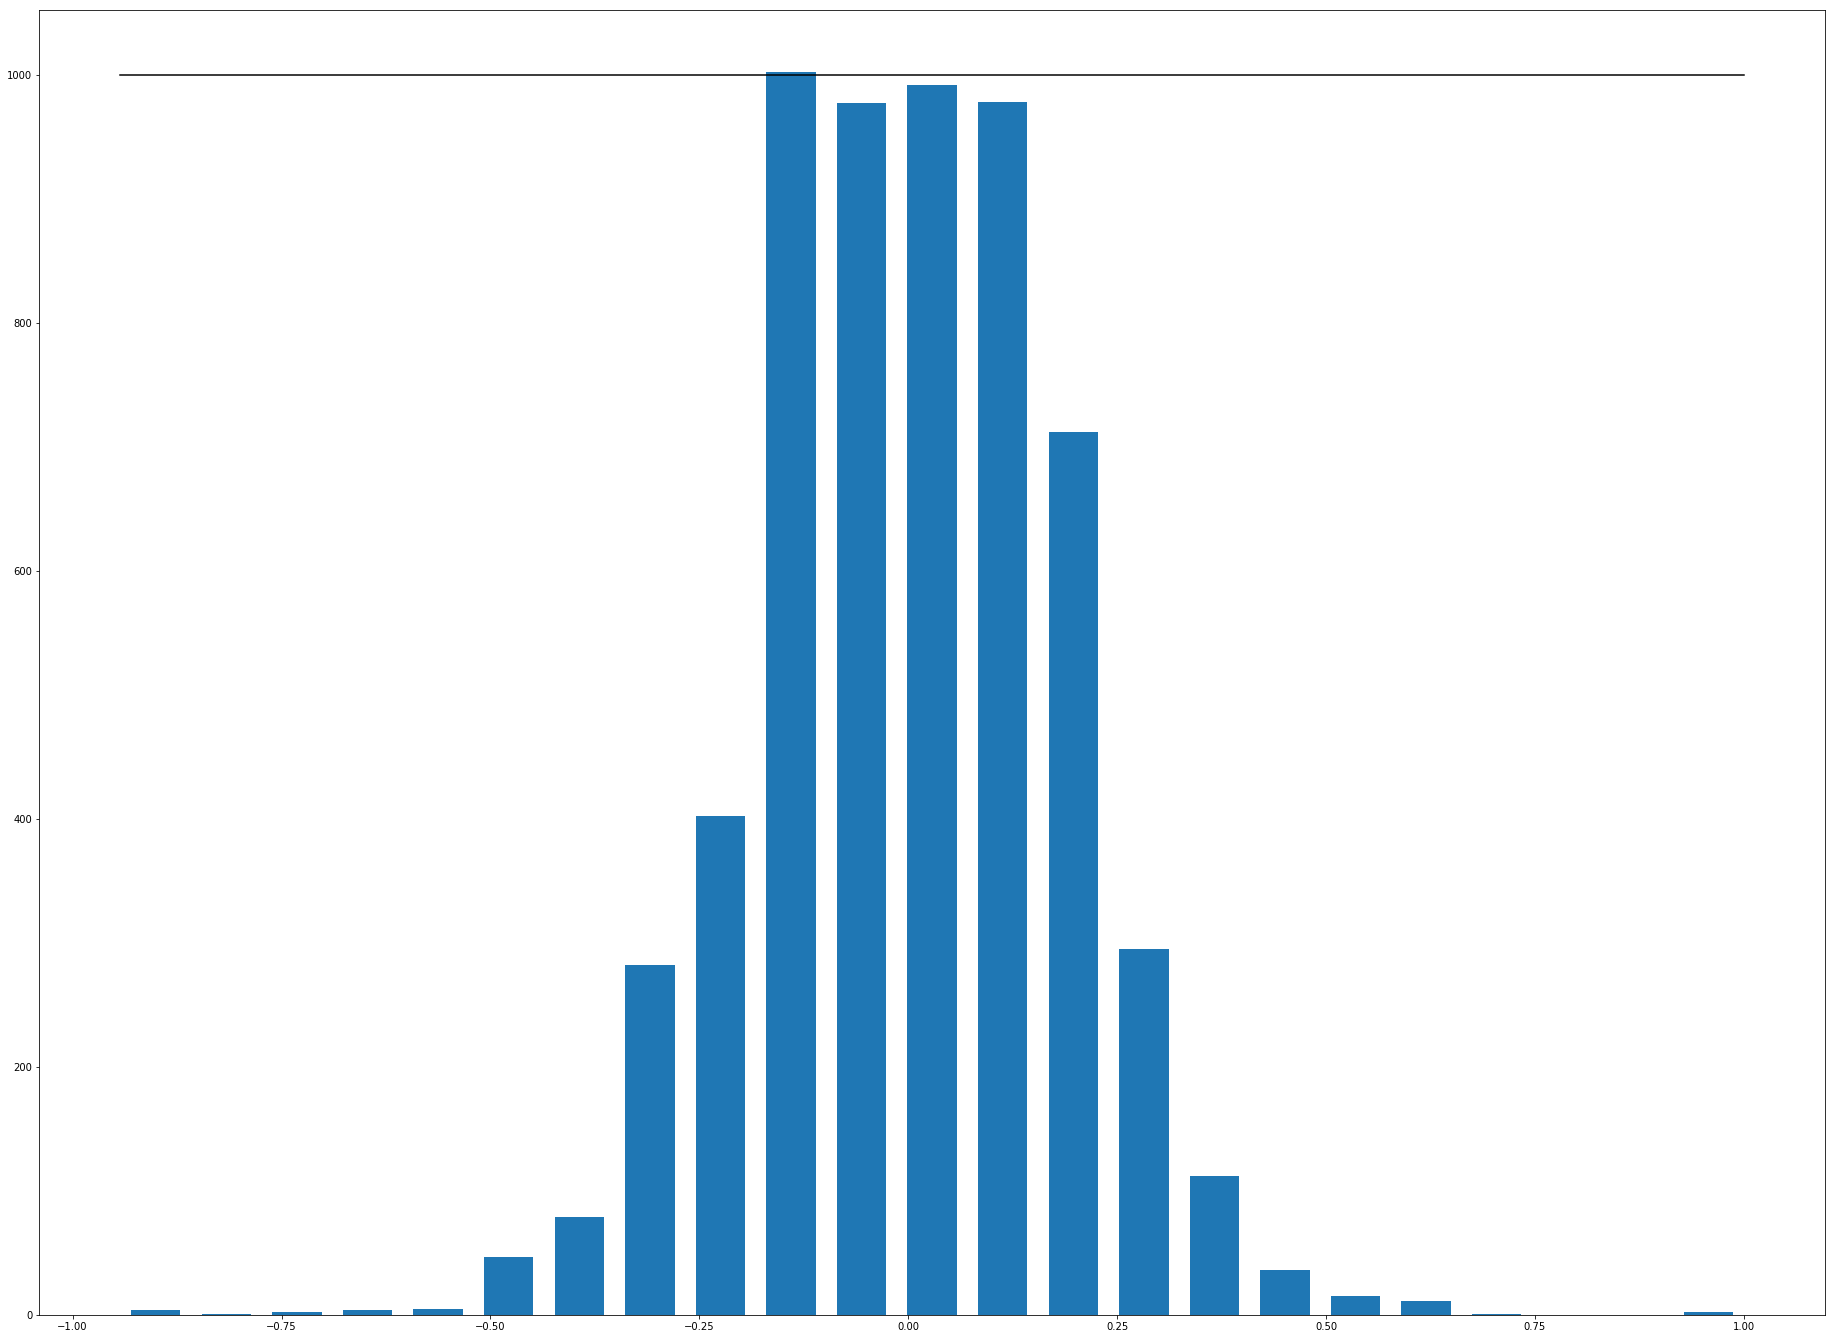

In [127]:

# determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
# to number of samples above the average, so as to bring the number of samples for that bin down to the average
keep_probs = []
target = avg_samples_per_bin #* .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(target/(hist[i]))
remove_list = []
for i in range(len(df["steering_angle"])):
    for j in range(num_bins):
        if df["steering_angle"][i] > bins[j] and df["steering_angle"][i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
                
df.drop(remove_list, inplace=True)
df = df.reset_index(drop=True)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(df["steering_angle"], num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(df["steering_angle"]), np.max(df["steering_angle"])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()


# Take a look at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# df_right = []
# df_left = []
# df_center = []
# for i in range(len(df)):
#     center_img = df["center_image"][i]
#     left_img = df["left_image"][i]
#     right_img = df["right_image"][i]
#     angle = df["steering_angle"][i]

#     if (angle > 0.1):
#         df_right.append([center_img, left_img, right_img, angle]) 
#         #reducing the samples with angles ranging between .15 and .2
# #         if(angle < .15)or(angle >.2):
#             # I'm adding a small deviation of the angle 
#             # This is to create more right turning samples for the same image
#         for i in range(5):
#             new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
#             df_right.append([center_img, left_img, right_img, new_angle])
            
#     elif (angle < -0.1):
#     if (angle < -0.):
#         df_left.append([center_img, left_img, right_img, angle])
        
#         # I'm adding a small deviation of the angle
#         # This is to create more left turning samples for the same image
#         for i in range(5):
#             new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
#             df_left.append([center_img, left_img, right_img, new_angle])
            
#     else:
#     if (angle != 0.0):
#     # Include all near 0 angle data
#         df_center.append([center_img, left_img, right_img, angle])            
#     else:
#         if np.random.uniform()>= 0.9: 
#             df_center.append([center_img, left_img, right_img, angle])
        
        

# print(len(df_center), len(df_left), len(df_right))

In [128]:
# # Shuffle the data so they're no longer sequential in the order that the data was collected
# random.shuffle(df_center)
# random.shuffle(df_left)
# random.shuffle(df_right)
# df_center = pd.DataFrame(df_center, columns=["center_image", "left_image", "right_image", "steering_angle"])
# df_left = pd.DataFrame(df_left, columns=["center_image", "left_image", "right_image", "steering_angle"])
# df_right = pd.DataFrame(df_right, columns=["center_image", "left_image", "right_image", "steering_angle"])

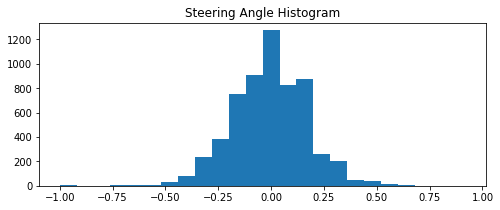

[[-1.0, -0.94999999999999996, 0],
 [-0.94999999999999996, -0.89999999999999991, 4],
 [-0.89999999999999991, -0.84999999999999987, 0],
 [-0.84999999999999987, -0.79999999999999982, 1],
 [-0.79999999999999982, -0.74999999999999978, 1],
 [-0.74999999999999978, -0.69999999999999973, 1],
 [-0.69999999999999973, -0.64999999999999969, 2],
 [-0.64999999999999969, -0.59999999999999964, 4],
 [-0.59999999999999964, -0.5499999999999996, 0],
 [-0.5499999999999996, -0.49999999999999956, 11],
 [-0.49999999999999956, -0.44999999999999951, 10],
 [-0.44999999999999951, -0.39999999999999947, 52],
 [-0.39999999999999947, -0.34999999999999942, 56],
 [-0.34999999999999942, -0.29999999999999938, 111],
 [-0.29999999999999938, -0.24999999999999933, 208],
 [-0.24999999999999933, -0.19999999999999929, 294],
 [-0.19999999999999929, -0.14999999999999925, 305],
 [-0.14999999999999925, -0.099999999999999201, 747],
 [-0.099999999999999201, -0.049999999999999156, 511],
 [-0.049999999999999156, 8.8817841970012523e-16, 

In [129]:
import pickle

# Make the train and valid list 
# data_list = [df_center, df_left, df_right]
# data_list_df = pd.concat(data_list, ignore_index=True)
data_list_df = df
len(data_list_df)
data_list_df.to_pickle('data.pickle')

# histogram after data augmentation
ts = data_list_df["steering_angle"]
plt.figure(figsize=(8,3))
plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.08))
plt.title("Steering Angle Histogram")
plt.show()

bins = np.arange(-1.0, 1.0, 0.05)
hist, bin_edges = np.histogram(df["steering_angle"], bins=bins)
# Create Steering Angle Bin Counts  
steer_bin = []
for i in range(len(hist)):
    steer_bin.append([bins[i], bins[i+1], hist[i]])
    
# Examine Steering Angle Bin Counts
steer_bin

## Data Preprocessing

In [130]:
# y_data is not used as it is already contained in X_data's column
# but I made it to conform to the train_test_split function format
X_data = data_list_df[["center_image","left_image","right_image","steering_angle"]]
y_data = data_list_df["steering_angle"]

X_data = pd.DataFrame(X_data, columns=["center_image", "left_image", "right_image", "steering_angle"])
y_data = pd.DataFrame(y_data, columns=["steering_angle"])
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_data, y_data, test_size=0.2)

# Resets the row index
X_train_data = X_train_data.reset_index(drop=True)
X_valid_data = X_valid_data.reset_index(drop=True)
# X_train_data[0:5]
print(len(X_train_data), len(X_valid_data))

4767 1192


In [131]:
## preprocessing utility functions
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    img_max = np.max(image_data)
    img_min = np.min(image_data)
    a = -0.5
    b = 0.5

    img_normed = a + (b-a)*(image_data - img_min)/(img_max - img_min)
    #print(np.max(img_normed))
    #print(np.min(img_normed))
    return img_normed

def normalize_color(image_data):
    """
    Normalize the image data on per channel basis. 
    """
    img_normed_color = np.zeros_like(image_data, dtype=float)
    for ch in range(image_data.shape[2]):
        tmp = normalize_grayscale(image_data[:,:,ch])
        img_normed_color[:,:,ch] = tmp
    #print(np.max(img_normed_color))
    #print(np.min(img_normed_color))
    return img_normed_color

def lower_luma(image):
    RATIO = 0.5
    cv2.imwrite("ori.png", image)
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
    image1[:,:,0] = RATIO*image1[:,:,0]
    image1 = cv2.cvtColor(image1,cv2.COLOR_YUV2RGB)
    cv2.imwrite("after.png", image1)
    return image1

def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def darker_img(image):
    # Convert to YUV
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_gray = img_yuv[:,:,0]
   
    # Pick the majority pixels of the image
    idx = (img_gray<245) & (img_gray > 10)
    
    # Make the image darker
    img_gray_scale = img_gray[idx]*np.random.uniform(0.1,0.6)
    img_gray[idx] = img_gray_scale
    
    # Convert back to BGR 
    img_yuv[:,:,0] = img_gray
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img

def warp_img(img, angle):
    '''
    Warp image horizontally, calculate the angle shifted then append to orig angle.
    '''
    WARP_DIV_RATIO = 5

    rows,cols,ch = img.shape
    
    # shifts within 1/(WARP_DIV_RATIO) of image width
    shifted_pixel = random.randint(-1*cols//WARP_DIV_RATIO,cols//WARP_DIV_RATIO)
    
    pts1 = np.float32([[cols//2,0],[0,rows-1],[cols-1,rows-1]])
    pts2 = np.float32([[cols//2+shifted_pixel,0],[0,rows-1],[cols-1,rows-1]])
    
    delta_angle = 0.004*shifted_pixel
    total_angle = angle + delta_angle
    #print(delta_angle, total_angle)
    
    M = cv2.getAffineTransform(pts1,pts2)
    warp_img = cv2.warpAffine(img,M,(cols,rows))
    #cv2.imwrite('test.png', img)
    #cv2.imwrite('test_warp.png', warp_img)
    return warp_img, total_angle

# Below func. copied from: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.kgjn97cup
def add_random_shadow(image):
    top_y = image.shape[1]*np.random.uniform()
    top_x = 0
    bot_x = image.shape[0]
    bot_y = image.shape[1]*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    random_bright = .15+.8*np.random.uniform()
    if np.random.randint(2)==1:
    #    random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

def trans_image(image,steer,trans_range, trans_y=False):
    """
    translate image and compensate for the translation on the steering angle
    """
    
    rows, cols, chan = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*.4
    
    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 40*np.random.uniform()-40/2
    else:
        tr_y = 0
    
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang


def crop_image(image, y1, y2, x1, x2):
    """
    crop image into respective size
    give: the crop extent
    """
    return image[y1:y2, x1:x2]

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def img_preprocess(image, steer_ang, train=True):
    """
    Apply processing to image
    """    
    # image size
    im_y = image.shape[0]
    im_x = image.shape[1]
    
    # translate image and compensate for steering angle
    trans_range = 50
    # image, steer_ang = trans_image(image, steer_ang, trans_range) # , trans_y=True
    
    if train == True and np.random.uniform()>= 0.5: #and abs(steer_ang) > 0.1
        image, steer_ang= warp_img(image, steer_ang)

    # crop image region of interest
    image = crop_image(image, 20, 140, 0+trans_range, im_x-trans_range)
    
    # flip image (randomly)
#     if train == True and np.random.uniform()>= 0.5 and abs(steer_ang) > 0.1:
#         image = cv2.flip(image, 1)
#         steer_ang = -steer_ang

    # augment brightness
    if train == True:
        image = augment_brightness(image)
    
    # perturb steering with a bias
    # steer_ang += np.random.normal(loc=0,scale=0.2)

    return image, steer_ang

(160, 320, 3)
(66, 200, 3)


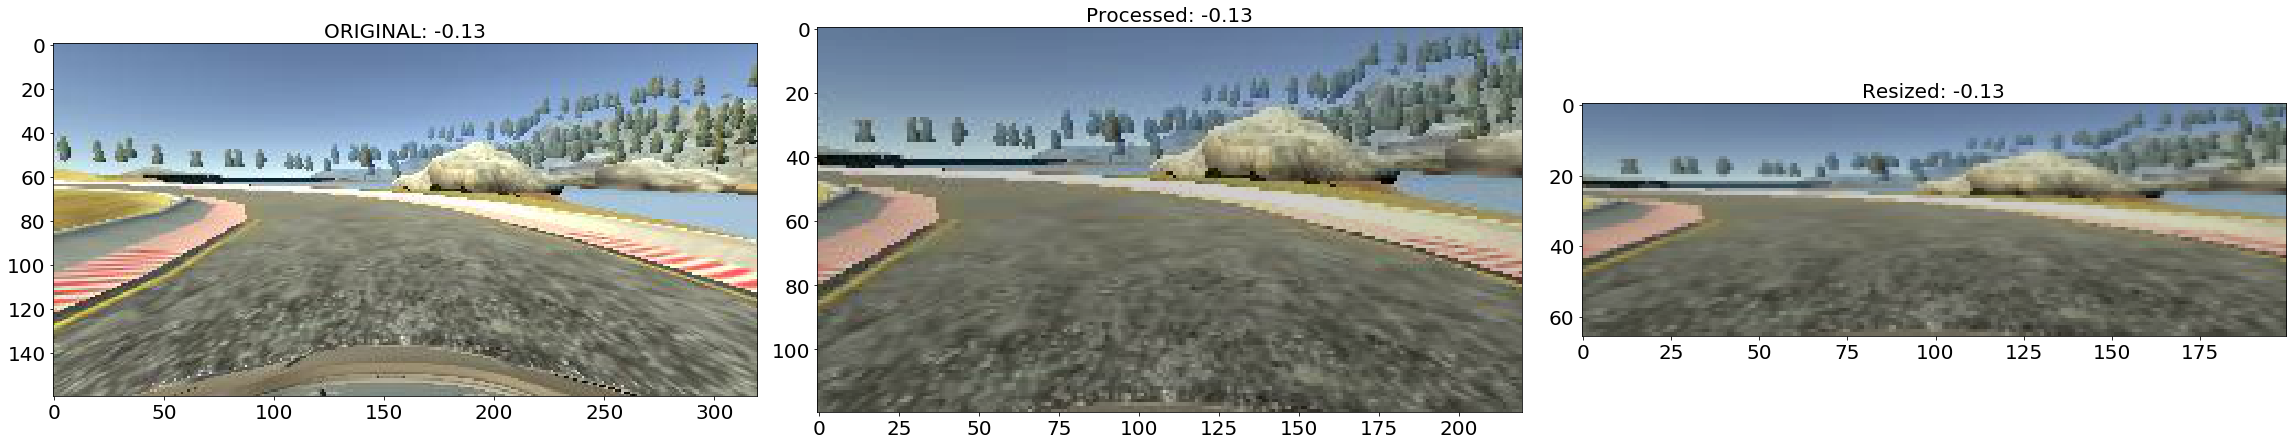

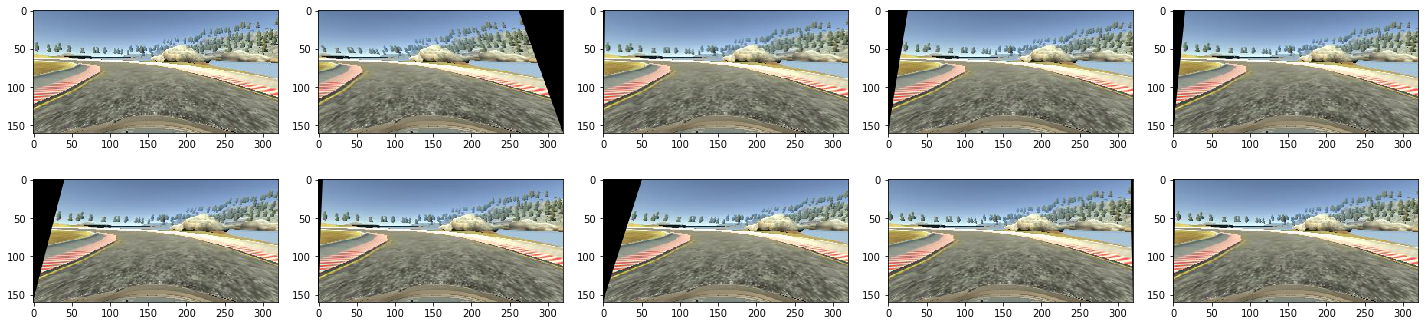

In [132]:
## Visualize preprocessed data
row, col, ch = img_center.shape
img_center = img_center.reshape(row, col, ch)
print(img_center.shape)
img_center_processed, angle_processed = img_preprocess(img_center, angle)
img_center_resized = cv2.resize(img_center_processed, (200,66), interpolation=cv2.INTER_AREA)
print(img_center_resized.shape)

plt.rcParams["figure.figsize"] = [32, 24]
plt.tick_params(axis='x', labelsize=25)
plt.subplot(1, 3, 1)
plt.imshow(img_center)
plt.title("ORIGINAL: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center_processed)
plt.title("Processed: " + str(np.round(angle_processed, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_center_resized)
plt.title("Resized: " + str(np.round(angle_processed, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
#         img = augment_brightness(img_center)
        img, new_angle = warp_img(img_center, 0.1)
        plt.imshow(img)

## Create the model

### Create the generator

In [133]:
_index_in_epoch = 0
batch_size = 64
img_height, img_width = 160, 320

####################################################################
def shuffle(x, y):
    perm = np.arange(len(x))
    np.random.shuffle(perm)
    x = x[perm]
    y = y[perm]

    return (x, y)

def load_training_and_validation_from_dataframe(df):
    rows, labels = [], []
    correction = 0.25 # this is a parameter to tune

    for idx in range(len(df)):
        angle = df['steering_angle'][idx]

        ## left image
        img_path = df['left_image'][idx]
        labels.append(angle + correction)
        rows.append(img_path)

        ## centre image
        img_path = df['center_image'][idx]
        labels.append(angle)
        rows.append(img_path)

        ## right image
        img_path = df['right_image'][idx]
        labels.append(angle - correction)
        rows.append(img_path)

    assert len(rows) == len(labels), 'unbalanced data'

    # shuffle the data
    X, Y = shuffle(np.array(rows), np.array(labels))

    # split into training and validation
    return train_test_split(X, Y, test_size = .25)

In [134]:
####################################################################

def next_batch(data, labels, batch_size):
    """
    Return the next `batch_size` examples from this data set.
    """
    global _index_in_epoch
    start = _index_in_epoch
    _index_in_epoch += batch_size
    _num_examples = len(data)

    if _index_in_epoch > _num_examples:
        # Shuffle the data
        data, labels = shuffle(data, labels)
        # Start next epoch
        start = 0
        _index_in_epoch = batch_size
        assert batch_size <= _num_examples

    end = _index_in_epoch
    return data[start:end], labels[start:end]

####################################################################

def transform_generator(x, y, batch_size, is_validation=False):
    while True:
        bad = []
        images, labels = list(), list()
        _images, _labels = next_batch(x, y, batch_size)
        for i in range(len(_images)):
            img = cv2.imread('data2/'+_images[i])
            if img is None: continue
            else: bad.append('/home/sameh/short-p/data2/{}'.format(_images[i]))
            img = img.reshape(img_height, img_width, 3)
            angle = _labels[i]

            #pre-processing
            img, angle = img_preprocess(img, angle, is_validation)
            img = cv2.resize(img, (200,66))
            
            images.append(img)
            labels.append(angle)

        X = np.array(images, dtype=np.float64).reshape((-1, 66, 200, 3))
        Y = np.array(labels, dtype=np.float64)            
        yield (X, Y)

### Build Model

In [135]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras.utils import np_utils

def gen_model(model_type = "nvidia"):
    model = Sequential()
    #data preprocessing: normalization
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66,200,3)))
    
    if model_type == "lenet":
        #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
        model.add(Convolution2D(6,5,5,activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(6,5,5,activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(120))
        model.add(Dense(84))
        model.add(Dense(1))

    if model_type == 'nvidia':  
        keep_prob = 0.5
        #model.add(Cropping2D(cropping=((65,25),(1,1))), input_shape=(img_height,img_width,3))
        model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(64,3,3,activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(64,3,3,activation='relu'))
        Dropout(keep_prob)
        model.add(Flatten())
        # layer 5, fc
        model.add(Dense(1164))
        model.add(Activation('relu'))
        model.add(Dropout(keep_prob))
        # layer 6, fc
        model.add(Dense(100))
        model.add(Activation('relu'))
        model.add(Dropout(keep_prob))
        # layer 7, fc
        model.add(Dense(50))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer 8, fc
        model.add(Dense(10))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer output
        model.add(Dense(1))

    if model_type == 'nvidia_v2':
                # -------------------------------------
        # Cover of NVidia end-to-end network (widen conv layers)
        # -------------------------------------
        # layer 1, conv
        model.add(Convolution2D(36, 5, 5, subsample=(2,2), input_shape=(66, 200, 3)))
        model.add(Activation('relu'))
        # layer 2, conv
        model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 3, conv
        model.add(Convolution2D(64, 5, 5, subsample=(2,2)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 4, conv
        model.add(Convolution2D(96, 3, 3))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 4, conv
        model.add(Convolution2D(96, 3, 3))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # Flatten
        model.add(Flatten())
        # layer 5, fc
        model.add(Dense(1164))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 6, fc
        model.add(Dense(100))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 7, fc
        model.add(Dense(50))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer 8, fc
        model.add(Dense(10))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer output
        model.add(Dense(1))

    adam = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
#     model.summary()
    return model

In [136]:
import time
nb_epoch = 5
batch_size = 256
print('nb_epoch = ', nb_epoch)
print('version: balance left and right turn data')
print('version: updated cropping and warping')
print('version: add recovery images - this helped')
print('version: only load centern images for recovery images - this helped')
print('version: chagne correction factor from .25 to .2 - this helped a lot !!!!')
print('version: try nvidia_v2 - not helped too much. need further verification')
print('version: added back left and right images from recovery drive')
print('version: disable upsampling')
print('version: disable warping')
print('version: tested with no left/right images for udacity data. removed recovery data - did not help')
print('version: flatten the input vecture: https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project')

start_time = time.time()
X_train, X_val, Y_train, Y_val = load_training_and_validation_from_dataframe(data_list_df) 

assert len(X_train) == len(Y_train), 'unbalanced training data'
assert len(X_val) == len(Y_val), 'unbalanced validation data'
print(len(X_train), "training images and ", len(X_val), "validation images")

model = gen_model(model_type='nvidia')

history = model.fit_generator(
    transform_generator(X_train, Y_train, batch_size = batch_size),
    samples_per_epoch=(len(X_train)),
    nb_epoch=nb_epoch,
    validation_data=transform_generator(X_val, Y_val, batch_size = batch_size, is_validation=True),
    nb_val_samples=len(X_val),
    verbose=1)

model.save('model.h5')

val_loss = history.history['val_loss'][0]

print("--- execution time %s seconds ---" % (time.time() - start_time))


nb_epoch =  5
version: balance left and right turn data
version: updated cropping and warping
version: add recovery images - this helped
version: only load centern images for recovery images - this helped
version: chagne correction factor from .25 to .2 - this helped a lot !!!!
version: try nvidia_v2 - not helped too much. need further verification
version: added back left and right images from recovery drive
version: disable upsampling
version: disable warping
version: tested with no left/right images for udacity data. removed recovery data - did not help
version: flatten the input vecture: https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project
13407 training images and  4470 validation images
Epoch 1/5
13312/13407 [============================>.] - ETA: 0s - loss: 0.0635

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


13568/13407 [==============================] - 32s - loss: 0.0631 - val_loss: 0.0569
Epoch 2/5
13568/13407 [==============================] - 25s - loss: 0.0370 - val_loss: 0.0442
Epoch 3/5
13568/13407 [==============================] - 26s - loss: 0.0313 - val_loss: 0.0428
Epoch 4/5
13568/13407 [==============================] - 25s - loss: 0.0295 - val_loss: 0.0414
Epoch 5/5
13568/13407 [==============================] - 25s - loss: 0.0280 - val_loss: 0.0441
--- execution time 138.07161116600037 seconds ---
